# Vector Representations

> *Data Science Unit 4 Sprint 2 Assignment 2*

## *Tobias Reaper*

---
---

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

---
---

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

---

### Use Requests to get the webpage

In [9]:
# ====== Generating the URLs ====== #

# base url is page 1 - looks like there are 10 postings per page
base_url = "https://www.indeed.com/jobs?q=data+science&l=Denver%2C+CO&start="
example_page2 = "https://www.indeed.com/jobs?q=data+science&l=Denver%2C+CO&start=10"

# Generate urls for all pages needed to get at least 100 (there are ~290 total)
urls = []  # List to hold generated urls

# Loop to generate the urls
for p in range(10, 290, 10):
    urls.append(base_url + str(p))

urls[:4]

['https://www.indeed.com/jobs?q=data+science&l=Denver%2C+CO&start=10',
 'https://www.indeed.com/jobs?q=data+science&l=Denver%2C+CO&start=20',
 'https://www.indeed.com/jobs?q=data+science&l=Denver%2C+CO&start=30',
 'https://www.indeed.com/jobs?q=data+science&l=Denver%2C+CO&start=40']

In [2]:
# ====== Using the URLs to get html ====== #
import requests
# To space out the requests, hopefully to prevent blacklist
from time import sleep

responses = []

for url in urls:
    response = requests.get(url_page1)

In [4]:
# Write the response text to an html file to use when parsing
with open("indeed_ds_denver.html", "w") as html:
    html.write(response.text)

### Use BeautifulSoup4 to parse the webpage

Using the Firefox devtools, I found that the job postings are located in a table...
 
> Still using tables for layouts...*How old is this site?*

```html
<td id="resultsCol">
  <div class="jobsearch-SerpJobCard unifiedRow row result clickcard">
    <div class="title"></div>
    <div class="sjcl">
      <div>
        <span class="company"></span>
        <!-- Companies with ratings -->
        <a href="" class="turnstileLink"></a>
      </div>
      <div class="location"></div>
    </div>
    <div class="summary">
      <ul></ul>
    </div>
  </div>
</td>
 ```

That should be enough to get me the data I need.

- Job title
- Job summary

However, the old data that JC provided seems to have the entire description for each one. To do that, another package is most likely necessary, such as selenium or scrapy.

> ## *~I will come back to this if there's time.~*

For now I'll use JC's old data.

In [16]:
# Load old indeed listings
oldf1 = pd.read_csv("data/job_listings.csv")

In [20]:
# First Lookz
pd.options.display.max_colwidth = 100
print(oldf1.shape)
oldf1.head()

(426, 3)


,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>\nConceptual understanding in Machine Learning mod...",Data scientist
1,1,"b'<div>Job Description<br/>\n<br/>\n<p>As a Data Scientist 1, you will help us build machine lea...",Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be working on consulting side of our business. You will b...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-u-xs-mb--md""><div class=""jobsearch-JobMetadataHead...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple locations</li>\n<li>2+ years of Analytics experien...,Data Scientist


In [13]:
# Take a closer look at some of the descriptions
df2.iloc[0]["description"]

'b"<div><div>Job Requirements:</div><ul><li><p>\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them</p>\\n</li><li><p>Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)</p>\\n</li><li><p>Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R</p>\\n</li><li><p>Ability to communicate Model findings to both Technical and Non-Technical stake holders</p>\\n</li><li><p>Hands on experience in SQL/Hive or similar programming language</p>\\n</li><li><p>Must show past work via GitHub, Kaggle or any other published article</p>\\n</li><li><p>Master\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field.</p></li></ul><div><div><div><div><div><d

...oh man, that is really bad. I may just try to do the scraping myself now. Might actually be easier, as there are no id's or anything.

I ended up spending far too long on it anyways. I did get a very clean dataset.

Observe!

---

## Indeed Job Scraping, Part Z

In [1]:
# ====== Imports ====== #
from bs4 import BeautifulSoup
import requests, json
import pandas as pd
from multiprocessing import Pool
from functools import partial

In [51]:
# ====== Class for scraping Indeed ====== #

class Scrape:
    def __init__(self, parameters):
        self.output_frame = None
        self.loading = False
        
        # Retain parameter dict
        self.parameters = parameters

        # Create base Indeed URL for all further scraping
        self.what = parameters["search_query"]
        self.where = parameters["location"]
        self.miles = parameters["miles"]
        self.base_url = f"https://www.indeed.com/jobs?q={self.what}&l={self.where}"
        
        # Set other attributes
        self.keywords = parameters["ordered_keywords"]
        self.title_keywords = parameters["title_keywords"]
        self.exclude_keywords = parameters["exclude_keywords"]
        self.pages = parameters["pages"]

        self.total_keywords = len(self.keywords) + len(self.title_keywords)

    def rate_job(self, j_title, j_soup):
        """Rate job based on input parameters."""

        description = j_soup.find(id="jobDescriptionText").get_text()

        # Reset the params
        keywords_present = []
        title_keywords_present = []
        rating = 0

        # Check for keyword, add value to rating depending on ranking
        for index, keyword in enumerate(self.keywords):
            if keyword in description:
                rating += len(self.keywords) - index
                keywords_present.append(keyword)

        # Check for title keywords
        for index, keyword in enumerate(self.title_keywords):
            if keyword in j_title:
                rating += self.total_keywords - index
                title_keywords_present.append(keyword)

        # Normalise rating
        rating = rating / sum(range(1, self.total_keywords + 1))

        # Check for excluded keywords
        for keyword in self.exclude_keywords:
            if keyword in j_title:
                rating = 0
                break

        return description, rating, keywords_present, title_keywords_present


    def get_job_details(self, job):
        """Obtain details of the job (company, title, description etc.)"""

        # Get link and title
        job_url = job.find(class_="title").a["href"]

        job_url = ( # Correct for truncated URLs
            "https://www.indeed.com" + job_url if (job_url.startswith("/")) else job_url
        )
        job_page = requests.get(job_url)
        job_soup = BeautifulSoup(job_page.content, "html.parser")

        # Give URL after redirect (ads/analytics etc.)
        job_url = job_page.url

        # Get job title and company name
        try:
            title = job.find(class_="title").a["title"]
        except:
            title = "No title found"
        
        try:
            company = job_soup.find(class_="icl-u-lg-mr--sm").get_text()
        except:
            company = "No company found."
            

        # Get description, rating and present keywords
        description, rating, keywords_present, title_keywords_present = self.rate_job(
            title, job_soup
        )

        return (
            title,
            company,
            job_url,
            description,
            rating,
            keywords_present,
            title_keywords_present,
        )

    def get_scrape(self):
        """Primary method for obtaining scraped jobs."""

        # Reset output and progress
        self.loading = True

        # Output list and frame
        output = []

        for x in range(0, self.pages):
            print(f"Processing page {x + 1}...")
            
            if x == 0:
                page_append = ""
            else:
                page_append = "&start=" + str(x * 10)

            # get page
            current_page = requests.get(self.base_url + page_append, timeout=5)
            page_soup = BeautifulSoup(current_page.content, "html.parser")

            for job in page_soup.select(".jobsearch-SerpJobCard"):
                (
                    title,
                    company,
                    url,
                    description,
                    rating,
                    keywords_present,
                    title_keywords_present,
                ) = self.get_job_details(job)
                output.append(
                    [
                        rating,
                        title,
                        company,
                        description,
                        url,
                        keywords_present,
                        title_keywords_present,
                        x + 1,
                    ]
                )

            print(f"Page {x+1} completed", end="\r")

        # Create dataframe from list of jobs
        df_output_frame = (
            pd.DataFrame(
                output,
                columns=[
                    "Rating",
                    "Job Title",
                    "Company",
                    "Description",
                    "Job URL",
                    "Keywords Present",
                    "Title Keywords",
                    "Page Found",
                ],
            )
            .sort_values(by="Rating", ascending=False)
            .reset_index(drop=True)
        )

        # Sort df by rating
        df_output_frame["Rating"] = df_output_frame["Rating"].round(decimals=3)
        df_output_frame = df_output_frame.drop_duplicates(
            subset=["Rating", "Job Title", "Company"]
        )
        self.loading = False

        return df_output_frame

In [52]:
# ====== Scraping parameters ====== #
parameters2 = {
    "search_query": "data science",
    "location": "Denver, CO",
    "miles": 50,
    "ordered_keywords": ["data", "science"],
    "exclude_keywords": "",
    "title_keywords": "",
    "pages": 15,
}

In [53]:
# First, instantiate a scraper object with the parameters
scraper2 = Scrape(parameters2)

In [54]:
# Then, use the `.get_scrape()` method to use the instance of the scraper
df2 = scraper2.get_scrape()

Processing page 1...
Processing page 2...
Processing page 3...
Processing page 4...
Processing page 5...
Processing page 6...
Processing page 7...
Processing page 8...
Processing page 9...
Processing page 10...
Processing page 11...
Processing page 12...
Processing page 13...
Processing page 14...
Processing page 15...


In [2]:
# There were more data cleaning and wrangling steps after this.
# The entire process can be found in `Indeed_Job_Scraper.ipynb`
step_3 = "profit"
print(f"""1. Scrape Indeed.com for data science job listings
2....?
3. {step_3}""")

1. Scrape Indeed.com for data science job listings
2....?
3. profit


---

### Now, the fun part - using the data I spend half a day obtaining

In [2]:
# Load the newly-scraped dataset
datapath = "19-12-03-indeed_jobs.csv"
df1 = pd.read_csv(datapath)

In [3]:
print(df1.shape)
df1.head(2)

(176, 6)


,job_title,company,description,job_url,keywords_present,page_found
0,Data Scientist,Aegis Premier Technologies,About Us We are a group of passionate technolo...,https://www.indeed.com/viewjob?cmp=Aegis-Premi...,NaN,1
1,Data Scientist,Merkle Inc.,"Job Description\n\nDesign, develop, test, depl...",https://www.indeed.com/viewjob?jk=9c9be388d642...,NaN,1


In [4]:
# Look at the string columns in a little more detail
df1.select_dtypes(exclude="number").describe().T.sort_values(by="unique")

,count,unique,top,freq
company,176,115,Deloitte,6
job_title,176,123,Data Scientist,26
description,176,176,"Passionate, resilient, customer focused, and a...",1
job_url,176,176,https://www.indeed.com/viewjob?jk=168be3ce7902...,1


In [5]:
# For the purposes of this analysis, I won't be needing some columns
df2 = df1.drop(columns=["job_url", "keywords_present", "page_found"])
print(df2.shape)

(176, 3)


In [6]:
# Set pandas display to wider columns
pd.options.display.max_colwidth = 200
df2.head(2)

,job_title,company,description
0,Data Scientist,Aegis Premier Technologies,"About Us We are a group of passionate technology professionals who are committed to delivering best-in-class data, data science and software solutions for the non-profit space. We care deeply abou..."
1,Data Scientist,Merkle Inc.,"Job Description\n\nDesign, develop, test, deploy and maintain machine learning techniques for Merkle data products. The products include identify, feature generation, propensity models, look-alike..."


---

## 2) Use Spacy to tokenize / clean the listings 

In [7]:
# ====== Imports ====== #

# Classix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# Spacy
import spacy
nlp = spacy.load("en_core_web_lg")

In [25]:
# Function to remove all non-alphanumeric characters
import re

def re_process(text):
    """Removes all non-alphanumeric characters from a string."""
    import re
    return re.sub(r"[^a-zA-Z ^0-9]", "", text)

In [28]:
# Give it a whirl
string = "sdj@@$fasjd,../.,/,./lfkj234fdg\\]|"

re_process(string)

'sdjfasjdlfkj234fdg'

In [8]:
# Function to tokenize / lemmatize the descriptions
def spacy_tokes(text):
    """Tokenizes text using spacy's english language model."""
    doc = nlp(text)
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [11]:
# Function to tokenize / lemmatize the descriptions
def get_lemmas(text):
    """Returns lemmas from text."""
    lemmas = []
    doc = nlp(text)

    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False) and (token.pos_ != "-PRON-")):
            lemmas.append(token.lemma_.strip())

    return lemmas

In [9]:
# Apply the tokenizer function to the descriptions
df3 = df2.copy()
df3["tokens"] = df3["description"].apply(spacy_tokes)

In [10]:
# Scope the results
df3["tokens"].head()

0    [group, passionate, technology, professional, commit, deliver, good, class, datum, datum, science, software, solution, non, profit, space, care, deeply, client, need, understand, work, direct, imp...
1    [Job, Description, , Design, develop, test, deploy, maintain, machine, learning, technique, Merkle, datum, product, product, include, identify, feature, generation, propensity, model, look, alike,...
2    [Deloitte, Services, LP, include, internal, support, area, Sales, Excellence, Marketing, Communications, Human, Resources, Talent, Information, Technology, Facilities, Management, Financial, Suppo...
3    [Job, SummaryJob, title, Data, Scientist||, Machine, learningWork, Location, Bloomfield, coduration, 12+monthsmust, skill, 1, 5):1, understanding, Statistics2, statistical, Programming3, Statistic...
4    [Honey, fast, grow, startup, base, Los, Angeles, online, shopping, platform, offer, user, smart, way, shop, simple, browser, extension, open, instant, access, exclusive, savin

---

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [ ]:
class Lemmizer(object):

    def __init__(self):
        self.nlp_ = spacy.load("en_core_web_lg")

    def __call__(self, doc):
        lemmas = []
        doc = self.nlp_(doc)
        
        for token in doc:
            if (
                (len(token.lemma_) > 1)
                or (token.lemma_.isalnum())
                and (token.is_stop != True)
                and (token.is_punct != True)
                and (token.pos_ not in ("PUNCT", "SYM", "-PRON-"))
            ):
                lemmas.append(token.lemma_.strip())
        
        return lemmas

In [29]:
# Instantiate the vectorizer using english stopwords
vect = CountVectorizer(preprocessor=re_process, tokenizer=get_lemmas, stop_words="english")

# Learn the vocabulary of the tokenized descriptions
vect.fit(df3["description"])

# Build the doc-term model
dtm_sparse = vect.transform(df3["description"])

# The output is a sparse matrix, which means that only terms with frequencies
# to show are included - no 0 values

# Shove that model into dense dataframe form (with 0 values)
# AKA hydrate that bad boii
dtm = pd.DataFrame(dtm_sparse.todense(), columns=vect.get_feature_names())

In [31]:
pd.options.display.max_columns = 200
print(dtm.shape)
dtm.head()

(176, 10811)


,,1,10,100,10000,100000,1000s,100B,101,1012,1015,10350,105,109,10x,11,11000,112020to,12,120,12000000,1212,1213,125,12985voluntary,12hour,12monthsmust,13,1300,14,140,15,15000,150000,151,15develop,15participate,16106605614,16th,17,1700,1718,172516,17630when,17646the,177495,179588,18,185000,18800,18month,19,190,1900,190000,1912334pearson,1914298pearson,1914749pearson,1985,1987,1994,1995,1998,1999,1b,1experience,1pm,1st,2,20,200,200075041would,200087442would,2002,2005,2009,2011,2012,2012one,2013,2014,2015our,2015recipient,2017,2018,2019,2019interviews,2019job,2019location,2019role,2019to,2020,2020applications,2020available,2020internship,2024,2030,20we,20year,21000,...,workmachine,workphysical,workplace,workplaceperforms,workprovide,workqualificationsexcellent,workshop,workshopshere,worksystem,workweek,workwork,workworke,world,worldA,worldAt,worldEven,worldIf,worldWed,worldclass,worldrecruit,worlds,worldspeak,worldwhile,worldwide,worldwideCitiusTech,worldwidewere,wrangle,wrangler,wrangling,write,writing,writingExperience,writingadditional,writingvery,written,writtenAbility,writtenoral,writtenverbal,wrong,www,wwwbianalytixcom,wwwcueducucareersuniversity,wwwdeloittecomusabout,wwwearthdatascienceorg,wwwearthdatascienceorgWhat,wwwearthdatascienceorgreview,wwwentercomcom,wwwicfcomcareer,wwwjumpcloudcom,wwwphoenixtmacomJob,wwwslingcom,wwwstarzcom,wwwterumobctcomcareer,wwwvailresortscareerscomVail,wwwxentitycom,x,x1,xentitywe,xml,xsdexperience,year,yearExperienceJava,yearFamily,yearJob,yearcompetitive,yearexperiencerelevant,yearlocated,yearround,yearsAdditional,yearsBig,yearsJob,yearsOur,yearsStrong,yearsWho,yearsadditional,yearsexperience,yearsfamiliarity,yearshandson,yearshave,yearsjava,yes,yield,yoga,youAbout,youBackground,youDeloittes,youHyperia,youWeve,youWhat,youWorking,youYou,youand,youas,youdo,youif,youour,youregardless,youresponsibilitie,youservicesource,zookeeper
0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---

## 4) Visualize the most common word counts

In [32]:
# === More Imports === #
from collections import Counter
import squarify

In [33]:
def count(docs):
    """Takes a corpus of docs and returns a df of word counts for analysis."""
    from collections import Counter

    word_counts = Counter()
    appears_in = Counter()
    
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())
    
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
    
    return wc.sort_values(by='rank')

In [34]:
# Use the Function
wc3 = count(df3['tokens'])

In [35]:
wc3.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
214,,167,4816,1.0,0.066854,0.066854,0.948864
74,datum,164,1384,2.0,0.019212,0.086066,0.931818
82,experience,173,1010,3.0,0.014020,0.100086,0.982955
69,work,171,769,4.0,0.010675,0.110761,0.971591
290,team,148,608,5.0,0.008440,0.119201,0.840909


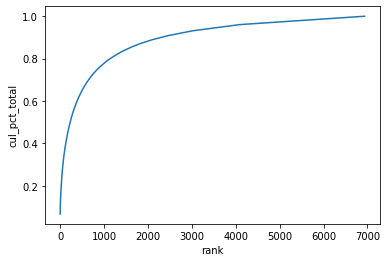

In [21]:
import seaborn as sns

# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc3);

In [23]:
wc3[wc3['rank'] <= 20]['cul_pct_total'].max()

0.183833532302396

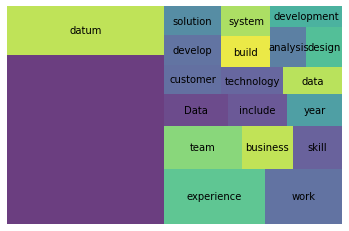

In [24]:
import squarify
import matplotlib.pyplot as plt

wc3_top20 = wc3[wc3['rank'] <= 20]

squarify.plot(sizes=wc3_top20['pct_total'], label=wc3_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

---

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [49]:
class LemmaSpace(object):

    def __init__(self):
        self.nlp_ = spacy.load("en_core_web_lg")
    
    def re_process(self, text):
        """Removes all non-alphanumeric characters from a string."""
        import re
        return re.sub(r"[^a-zA-Z ^0-9]", "", text)

    def __call__(self, doc):

        doc = self.re_process(doc)
        doc = self.nlp_(doc)

        lemmas = []

        for token in doc:
            if (
                (len(token.lemma_) > 1)
                or (token.lemma_.isalnum())
                and (token.is_stop != True)
                and (token.is_punct != True)
                and (token.pos_ not in ("PUNCT", "SYM"))
            ):
                lemmas.append(token.lemma_.strip())

        return lemmas

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(tokenizer=LemmaSpace(), min_df=0.025, max_df=.98)

# Create a vocabulary
tf_dtm = tfidf.fit(df3["description"])

# Get word counts per document
sparse_dtm = tfidf.transform(df3["description"])

# Get feature names (words) for dataframe column headers
vdtm = pd.DataFrame(sparse_dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
vdtm.head()

,-PRON-,1,10,100,12,13,15,18,2,20,2017,2018,2019,3,30,35,3rd,4,40,401k,5,50,500,6,7,800,ab,ability,able,about,above,academic,accelerate,accept,access,accessible,accommodation,accomplish,account,accredit,accuracy,accurate,achieve,acquire,acquisition,across,act,action,actionable,active,actively,activity,ad,adapt,add,addition,additional,address,adhere,adhoc,administration,adoption,advance,advanced,advantage,advertising,advise,affect,affirmative,after,against,age,agency,agent,agile,agility,ai,aid,aim,aiml,air,airflow,algorithm,align,all,allen,allow,along,also,alternative,alteryx,always,amazing,amazon,ambiguity,american,among,amount,an,analysis,...,ultimately,uncertainty,uncover,under,understand,understanding,unique,unit,united,university,unlawful,unlock,unmatched,unstructured,unsupervised,until,up,update,upon,uptodate,usage,use,user,utilize,vacation,validate,validation,valuable,value,variable,varied,variety,various,vary,vast,vehicle,vendor,verbal,verification,verify,version,very,veteran,via,video,view,visible,vision,visit,visual,visualization,voice,volume,volunteer,walk,want,warehouse,warehousing,water,way,weakness,weather,web,website,week,weekend,welcome,well,what,when,where,whether,which,while,who,why,wide,will,willing,willingness,win,window,within,without,woman,work,worker,workflow,workforce,working,workplace,world,worldclass,worldwide,would,write,writing,year,yes,yet
0,0.193388,0.058329,0.0,0.0,0.0,0.0,0.0,0.0,0.050099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055171,0.0,0.0,0.0,0.0,0.0,0.0,0.033686,0.000000,0.079356,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.068276,0.0,0.0,0.0,0.040001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.050099,0.0,0.028960,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.092616,...,0.0,0.0,0.0,0.0,0.036718,0.036994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.112090,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.07998,0.0,0.0,0.0,0.0,0.065570,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042433,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.050663,0.000000,0.0,0.000000,0.000000,0.072891,0.0,0.0,0.044072,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.019893,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069618,0.0,0.0
1,0.260110,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.061258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.080175,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.097794,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.035411,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.151921,0.0,0.0,0.0,0.000000,0.078113,0.037748,...,0.0,0.0,0.0,0.0,0.000000,0.045234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.109645,0.000000,0.0,0.0,0.0,0.0,0.000000,0.046999,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.062659,0.0,0.0,0.0,0.000000,0.0,0.0,0.205098,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.053772,0.0,0.054778,0.000000,0.000000,0.0,0.0,0.026944,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.048649,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028375,0.0,0.0
2,0.156841,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.054966,0.0,0.0,0.0,0.0,0.000000,0.0,

---

## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [52]:
ideal = """The ability to work from home, and the freedom to pursue some variety of projects at different levels in the organization. The general culture should be intensely creative, dedicated, inspired, intelligent, and outrageously fun when the situation called for it."""

In [56]:
# Instantiate the NN model
from sklearn.neighbors import NearestNeighbors

# Fit on TF-IDF Vectors
nn  = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(vdtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [57]:
# Turn my ideal description into a vector using the tf-idf vocab created above
ideal_vec = tfidf.transform([ideal])

In [58]:
rec_array = nn.kneighbors(ideal_vec.todense(), n_neighbors=5)
rec_array

(array([[1.26612766, 1.2818643 , 1.30010656, 1.30440101, 1.30547742]]),
 array([[ 80,  56,  95, 110, 174]]))

In [59]:
# Extract the second array - the list of strain ids (indexes) that are 'closest' to input
rec_id_list = rec_array[1][0]
rec_id_list

array([ 80,  56,  95, 110, 174])

In [64]:
# Hydrate that list with the rest of the data from the original dataframe
recommendations = df3.iloc[rec_id_list]
recommendations

,job_title,company,description,tokens
80,Data Engineer,Havenly,"At Havenly, we believe everyone deserves a beautiful home that they love. Through our proprietary technology and our team of talented designers, we make designing and shopping for your home, fun, ...","[Havenly, believe, deserve, beautiful, home, love, proprietary, technology, team, talented, designer, design, shop, home, fun, easy, accessible, , role, work, closely, Data, Scientists, Product, M..."
56,Head of Data Science,Front Door,"Company Overview\nFrontdoor is a company that’s obsessed with taking the hassle out of owning a home. With services powered by people and enabled by technology, it is the parent company of four ho...","[company, Overview, , Frontdoor, company, ’, obsessed, take, hassle, own, home, service, power, people, enable, technology, parent, company, home, service, plan, brand, American, Home, Shield, HSA..."
95,"Siri - Analytics Engineer, Data Organization",Apple,"Summary\nPosted: Nov 18, 2019\nRole Number: 200075041\nWould you like to play a part in the next revolution in human- computer interaction? Create groundbreaking technology for large scale systems...","[summary, , post, Nov, 18, 2019, , role, number, 200075041, , like, play, revolution, human-, computer, interaction, create, groundbreake, technology, large, scale, system, speak, language, big, d..."
110,"Siri - Analytic Engineer, Data Organization",Apple,"Summary\nPosted: Nov 18, 2019\nRole Number: 200087442\nWould you like to play a part in the next revolution in human- computer interaction? Create groundbreaking technology for large scale systems...","[summary, , post, Nov, 18, 2019, , role, number, 200087442, , like, play, revolution, human-, computer, interaction, create, groundbreake, technology, large, scale, system, speak, language, big, d..."
174,Machine Learning/AI Engineer,Josh.ai,"Overview:\nAt Josh.ai we are innovating at the intersection of voice control, artificial intelligence, and home automation in order to create the world's most technologically advanced homes. We're...","[overview, , josh.ai, innovate, intersection, voice, control, artificial, intelligence, home, automation, order, create, world, technologically, advanced, home, team, enthusiastic, software, engin..."


---
---

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 